<table style="border: none" align="center">
   <tr style="border: none">
      <th style="border: none"><font face="verdana" size="4" color="black"><b>  EXP:1 Model Train and Evaluation: ensemble learning  </b></font></font></th>
   </tr> 
</table>

In this notebook we demonstrate Model training and adversarial training using ART on the IRIS dataset.

Sensitivity to training set details:
https://nbviewer.jupyter.org/github/Azure/azureml-examples/blob/main/notebooks/train-lightgbm-local.ipynb


## Contents

1.	[Load prereqs and data](#prereqs)
2.  [Data scale, Train and evaluate a baseline classifier](#classifier)
3.  [Adversarially train a robust classifier](#adv_training)
4.	[Evaluate the robust classifier](#evaluation)

<a id="prereqs"></a>
## 1. Load prereqs and data

In [47]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [48]:
%watermark

2020-11-24T23:41:32+01:00

CPython 3.8.3
IPython 7.19.0

compiler   : MSC v.1916 64 bit (AMD64)
system     : Windows
release    : 7
machine    : AMD64
processor  : Intel64 Family 6 Model 37 Stepping 5, GenuineIntel
CPU cores  : 4
interpreter: 64bit


In [49]:
# Initialization:
%reload_ext autoreload
%autoreload 2

# import warnings filter
import warnings
warnings.filterwarnings('ignore')
# ignore all future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [51]:
%reload_ext watermark
%watermark  -d -u -a "Habtamu desalegn" -v -p numpy,pandas,scipy,matplotlib,sklearn,mlxtend

Habtamu desalegn 
last updated: 2020-11-24 

CPython 3.8.3
IPython 7.19.0

numpy 1.19.4
pandas 1.1.3
scipy 1.5.3
matplotlib 3.3.3
sklearn 0.23.2
mlxtend 0.17.3


In [50]:
# Downloading the Libraries and Dependencies:
import os
import numpy as np
import pandas as pd
from IPython.display import Image
from typing import Tuple
%matplotlib inline
import matplotlib.pyplot as plt

#### Loading the IRIS dataset

In [52]:
COLUMNS = ["sepal_length","sepal_width","petal_length","petal_width","species"]
PATH = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
df = pd.read_csv(PATH, header=None, index_col=None, names = COLUMNS)
df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [53]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df.loc[:,'species'] = le.fit_transform(df.loc[:,'species'].values)

df.to_csv("data/iris_transformed.csv",sep=',',index=False)

In [54]:
df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [55]:
df["species"].values

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [56]:
# balanced data
df.groupby(['species']).count()

,sepal_length,sepal_width,petal_length,petal_width
species,,,,
0,50,50,50,50
1,50,50,50,50
2,50,50,50,50


In [57]:
# Feature , Lable
X = df.drop('species', axis=1).values
y = df['species'].values

In [58]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42,shuffle=True)

In [59]:
print(f'X_train.shape: {X_train.shape}')
print(f'y_train.shape: {y_train.shape}')
print(f'X_test.shape: {X_test.shape}')
print(f'y_test.shape: {y_test.shape}')

X_train.shape: (105, 4)
y_train.shape: (105,)
X_test.shape: (45, 4)
y_test.shape: (45,)


<a id="classifier"></a>
## 2. Preprocess ,Train and Evaluate a classifier

1. [Data Scaling](#2_1)
2. [Model Train and Evaluation: ensemble learning](#2_2)
3. [Evaluate the model](#2_3)

<a id="2_1"></a>
### 1. Data Scaling

Bringing features onto the same scale

In [60]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

def preprocess_minmax(X_train: np.ndarray, X_test: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    Normalization -- Min-max scaling

    Scales `X_train` to [0, 1] , `X_test` to [0, 1]

    :param X_train: Data instances.
    :param X_test: Data instances.
    :return: Rescaled values of `X_train`, `X_test`.
    """
    
    # normalize
    #print('normalized:', (ex - ex.min()) / (ex.max() - ex.min()))
    
    mms = MinMaxScaler()
    X_train_norm = mms.fit_transform(X_train)
    X_test_norm = mms.transform(X_test)
    
    return X_train_norm, X_test_norm

def preprocess_standard(X_train: np.ndarray, X_test: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    Standard scaling: Gaussian with zero mean and unit variance

    Scales `X_train` to [0, 1] , `X_test` to [0, 1]

    :param x: Data instances.
    :param y: Labels.
    :return: Rescaled values of `x`, `y`.
    """
    
    stdsc = StandardScaler()
    X_train_std = stdsc.fit_transform(X_train)
    X_test_std = stdsc.transform(X_test)
    
    return X_train_std, X_test_std

In [61]:
# Preprocess - Training and testing set
### standard
#(X_train, X_test) = preprocess_standard(X_train[:,[0,1]], X_test[:,[0,1]])    #  0=sepal length, 1=sepal width
(X_train, X_test) = preprocess_standard(X_train[:,2:], X_test[:,2:])           #  2=petal length, 3=petal width

### normalize
#(X_train, X_test) = preprocess_minmax(X_train[:,[0,1]], X_test[:,[0,1]])     #  0=sepal length, 1=sepal width
#(X_train, X_test) = preprocess_minmax(X_train[:,2:], X_test[:,2:])           #  2=petal length, 3=petal width

### with out normalization
#(X_train, X_test) = X_train[:,[0,1]], X_test[:,[0,1]]      #  0=sepal length, 1=sepal width
#(X_train, X_test) = X_train[:,2:], X_test[:,2:]            #  2=petal length, 3=petal width


In [62]:
X_train.shape

(105, 2)

In [63]:
X_train[0:5]

array([[-0.10014569, -0.32149987],
       [ 0.71771076,  0.35364985],
       [ 0.95138404,  0.75873969],
       [ 0.30878254,  0.21861991],
       [ 1.30189395,  1.7039493 ]])

In [64]:
y_train

array([1, 2, 2, 1, 2, 1, 2, 1, 0, 2, 1, 0, 0, 0, 1, 2, 0, 0, 0, 1, 0, 1,
       2, 0, 1, 2, 0, 2, 2, 1, 1, 2, 1, 0, 1, 2, 0, 0, 1, 1, 0, 2, 0, 0,
       1, 1, 2, 1, 2, 2, 1, 0, 0, 2, 2, 0, 0, 0, 1, 2, 0, 2, 2, 0, 1, 1,
       2, 1, 2, 0, 2, 1, 2, 1, 1, 1, 0, 1, 1, 0, 1, 2, 2, 0, 1, 2, 2, 0,
       2, 0, 1, 2, 2, 1, 2, 1, 1, 2, 2, 0, 1, 2, 0, 1, 2])

<a id="2_2_1"></a>
### 2.1 Model Training: Fit a Ensemble Methods via scikit-learn

In [65]:
# Ref: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
# Ref: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

tree  = DecisionTreeClassifier(criterion='entropy', max_depth=32, min_samples_leaf=1, random_state=42)

model = BaggingClassifier(base_estimator=tree,
                        n_estimators=10,
                        oob_score=True,
                        bootstrap=True,
                        bootstrap_features=False,
                        n_jobs=1,
                        random_state=42)

model.fit(X_train, y_train)


print(f'model: {model}')
print("OOB Accuracy: %0.2f" % model.oob_score_)
print("Test Accuracy: %0.2f" % model.score(X_test, y_test))

model: BaggingClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy',
                                                        max_depth=32,
                                                        random_state=42),
                  n_jobs=1, oob_score=True, random_state=42)
OOB Accuracy: 0.93
Test Accuracy: 1.00


<a id="2_3"></a>
### Evaluate the model

Looking at different performance evaluation metrics

In [66]:
from sklearn import metrics
from sklearn.preprocessing import LabelBinarizer

def multiclass_roc_auc_score(y_test, y_pred, average='macro'):
    lb = LabelBinarizer()
    y_test_bin = lb.fit_transform(y_test)
    y_pred_bin = lb.fit_transform(y_pred)
    
    return metrics.roc_auc_score(y_test_bin, y_pred_bin, average)

# using predict_proba
# y_proba  = model.predict_proba(X_test)
#print(f"class probabilities:\n {y_proba }")
# y_pred = y_proba.argmax(axis=1)

y_pred = model.predict(X_test)
print(f"prediction: {y_pred}")
print(f"y_true: {y_test}")
print(f'Misclassified examples:{(y_test != y_pred).sum()}')

# Confusion Matrix
conf_mat = metrics.confusion_matrix(y_test, y_pred)
print(f"confusion matrix:\n {conf_mat}")

# Accuracy
accuracy = metrics.accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Precision
print('\n[Precision]')
precision = metrics.precision_score(y_test, y_pred, average=None)
print(f'Individual: {precision[0]:.2f}, {precision[1]:.2f}, {precision[2]:.2f}')
precision = metrics.precision_score(y_test, y_pred, average='micro')
print(f"micro: {precision}")
precision = metrics.precision_score(y_test, y_pred, average='macro')
print(f"macro: {precision}")

# Recall
print('\n[Recall]')
recall = metrics.recall_score(y_test, y_pred, average=None)
print(f'Individual: {recall[0]:.2f}, {recall[1]:.2f}, {recall[2]:.2f}')
recall = metrics.recall_score(y_test, y_pred, average='micro')
print(f"micro: {recall}")
recall = metrics.recall_score(y_test, y_pred, average='macro')
print(f"macro: {recall}")

# F1
print('\n[F1-score]')
f1 = metrics.f1_score(y_test, y_pred, average=None)
print(f'Individual: {f1[0]:.2f}, {f1[1]:.2f}, {f1[2]:.2f}')
f1 = metrics.f1_score(y_test, y_pred, average='micro')
print(f"micro: {f1}")
f1 = metrics.f1_score(y_test, y_pred, average='macro')
print(f"macro: {f1}")

# AUC
print('\n[ROC AUC]')
auc = multiclass_roc_auc_score(y_test, y_pred, average='macro')
print(f"macro: {auc}")

# classification_report
print(f"\nclassification_report:\n {metrics.classification_report(y_test, y_pred)}")

# Predicting classes and class probabilities
print(f"\nX_test:\n {X_test[0:5,:]}")
print(f"\nclass probabilities:\n {model.predict_proba(X_test[0:5,:])}")
print(f"\nPredicting classes: {model.predict(X_test[0:5,:])}")

prediction: [1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0 0 0 1 0 0 2 1
 0 0 0 2 1 1 0 0]
y_true: [1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0 0 0 1 0 0 2 1
 0 0 0 2 1 1 0 0]
Misclassified examples:0
confusion matrix:
 [[19  0  0]
 [ 0 13  0]
 [ 0  0 13]]
Accuracy: 1.0

[Precision]
Individual: 1.00, 1.00, 1.00
micro: 1.0
macro: 1.0

[Recall]
Individual: 1.00, 1.00, 1.00
micro: 1.0
macro: 1.0

[F1-score]
Individual: 1.00, 1.00, 1.00
micro: 1.0
macro: 1.0

[ROC AUC]
macro: 1.0

classification_report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00        13
           2       1.00      1.00      1.00        13

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45


X_test:
 [[ 0.48403749 -0.05143998]
 [-1.26851205 -1.26670948]
 [ 1.76924049  1.43

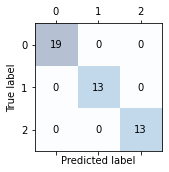

In [67]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(conf_mat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_mat.shape[0]):
    for j in range(conf_mat.shape[1]):
        ax.text(x=j, y=i, s=conf_mat[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
plt.show()

## 5 Adversarial-Robustness-Toolbox for scikit-learn Ensemble Learning